# Padim Example

#### Import dependencies

In [1]:
import os
import anodet
import numpy as np
import torch
import cv2
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 

## Training

In this notebook the MVTec dataset will be used. It can be downloaded from: https://www.mvtec.com/company/research/datasets/mvtec-ad.

Change `DATASET_PATH` to the path where you save the dataset.

Also, if you want to save and load the model. Add a folder where to save them and change the path of `MODEL_DATA_PATH` to that folder.

In [2]:
DATASET_PATH = os.path.realpath("../data_warehouse/dataset")
MODEL_DATA_PATH = os.path.realpath("./distributions/")

#### Load dataset

In [3]:
object_name = "purple_duck"
camera_name = "cam_0_left"
dataset = anodet.AnodetDataset(os.path.join(DATASET_PATH, f"{object_name}/train/good/{camera_name}"))
dataloader = DataLoader(dataset, batch_size=32)
print("Number of images in dataset:", len(dataloader.dataset))

Number of images in dataset: 150


#### Init the model

In [4]:
padim = anodet.Padim(backbone='resnet18')

#### Fit the model to the dataset

In [5]:
padim.fit(dataloader)

Feature extraction:   0%|          | 0/5 [00:00<?, ?it/s]

Feature extraction: 100%|██████████| 5/5 [00:12<00:00,  2.42s/it]


#### Save the necessary parameters

In [6]:
distributions_path = './distributions/'
torch.save(padim.mean, os.path.join(MODEL_DATA_PATH, f"{object_name}_{camera_name}_mean.pt"))
torch.save(padim.cov_inv, os.path.join(MODEL_DATA_PATH, f"{object_name}_{camera_name}_cov_inv.pt"))

# 

## Inference
#### Load test images

In [7]:
anomaly = ["albinism"]

paths = [
    os.path.join(DATASET_PATH, f"{object_name}/test/{anomaly[0]}/{camera_name}/000.png"),
    os.path.join(DATASET_PATH, f"{object_name}/test/{anomaly[0]}/{camera_name}/001.png"),
    os.path.join(DATASET_PATH, f"{object_name}/test/{anomaly[0]}/{camera_name}/002.png"),
    os.path.join(DATASET_PATH, f"{object_name}/test/good/{camera_name}/000.png"),
    os.path.join(DATASET_PATH, f"{object_name}/test/good/{camera_name}/001.png"),
]

images = []
for path in paths:
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(image)

batch = anodet.to_batch(images, anodet.standard_image_transform, torch.device('cpu'))

#### Load the model data

In [8]:
mean = torch.load(os.path.join(MODEL_DATA_PATH, f"{object_name}_{camera_name}_mean.pt")) 
cov_inv = torch.load(os.path.join(MODEL_DATA_PATH, f"{object_name}_{camera_name}_cov_inv.pt"))

#### init the model

In [9]:
padim = anodet.Padim(backbone='resnet18', mean=mean, cov_inv=cov_inv, device=torch.device('cpu'))

#### Make prediction

In [10]:
image_scores, score_maps = padim.predict(batch)

#### Interpret the prediction

In [11]:
THRESH = 13
score_map_classifications = anodet.classification(score_maps, THRESH)
image_classifications = anodet.classification(image_scores, THRESH)
print("Image scores:", image_scores)
print("Image classifications:", image_classifications)

Image scores: tensor([21.4262, 18.2832, 18.3564,  8.6248,  4.7996])
Image classifications: tensor([0., 0., 0., 1., 1.])


#### Visualization

In [12]:
test_images = np.array(images).copy()

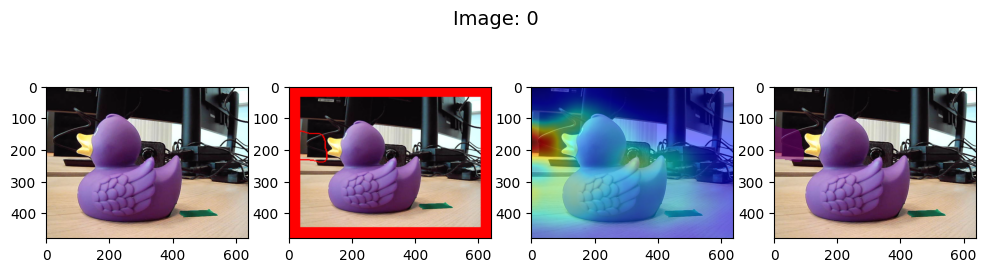

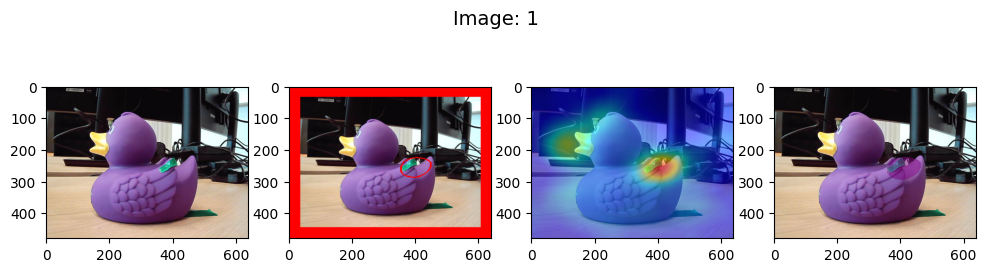

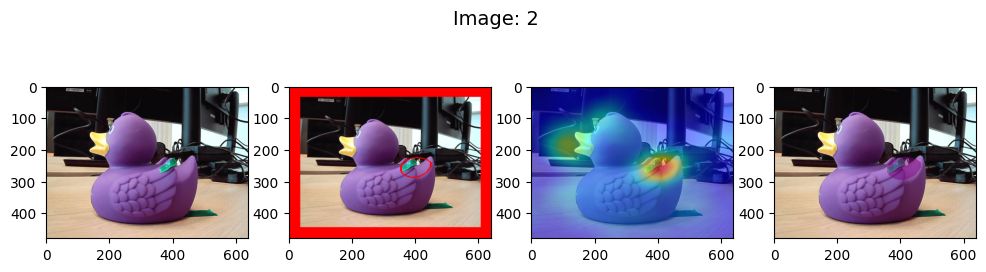

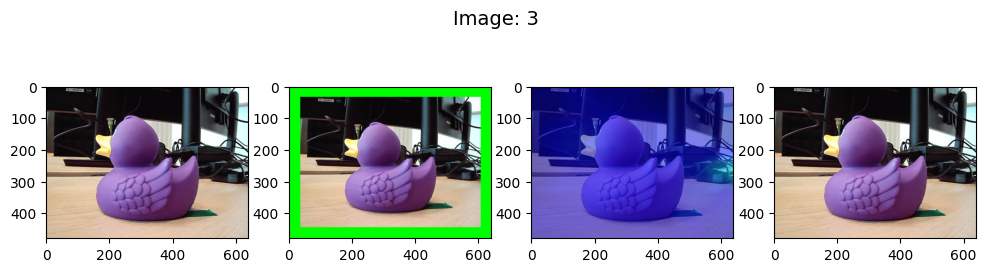

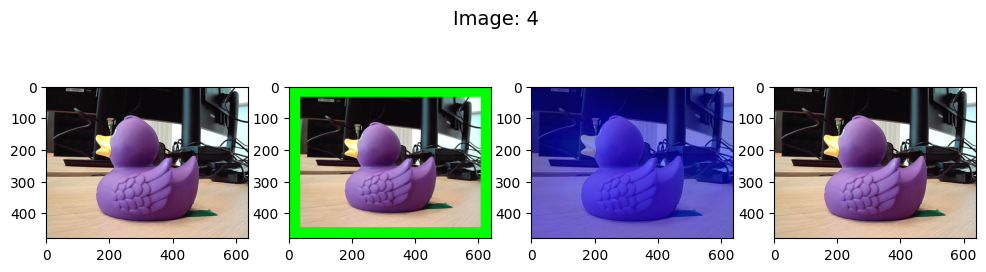

In [13]:
boundary_images = anodet.visualization.framed_boundary_images(test_images, score_map_classifications, image_classifications, padding=40)
heatmap_images = anodet.visualization.heatmap_images(test_images, score_maps, alpha=0.5)
highlighted_images = anodet.visualization.highlighted_images(images, score_map_classifications, color=(128, 0, 128))

for idx in range(len(images)):
    fig, axs = plt.subplots(1, 4, figsize=(12, 6))
    fig.suptitle('Image: ' + str(idx), y=0.75, fontsize=14)
    axs[0].imshow(images[idx])
    axs[1].imshow(boundary_images[idx])
    axs[2].imshow(heatmap_images[idx])
    axs[3].imshow(highlighted_images[idx])
    plt.show()

#### For one merged image

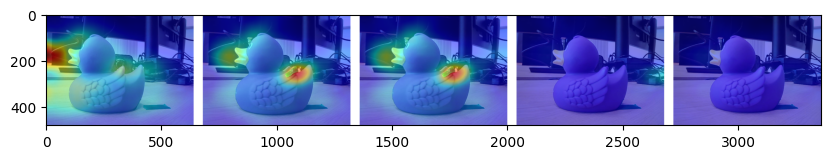

In [14]:
heatmap_images = anodet.visualization.heatmap_images(test_images, score_maps, alpha=0.5)
tot_img = anodet.visualization.merge_images(heatmap_images, margin=40)
fig, axs = plt.subplots(1, 1, figsize=(10, 6))
plt.imshow(tot_img)
plt.show()

#### Model Evaluation

In [15]:
#  DATASET_PATH = os.path.realpath("../data_warehouse/dataset")

test_dataset = anodet.MVTecDataset(DATASET_PATH, object_name, is_train=False)
test_dataloader = DataLoader(test_dataset, batch_size=32)

ValueError: class_name: purple_duck, should be in ['bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather', 'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']

In [ ]:
res = padim.evaluate(test_dataloader)
images, image_classifications_target, masks_target, image_scores, score_maps = res

Inference: 0it [00:00, ?it/s]


In [ ]:
anodet.visualize_eval_data(image_classifications_target, masks_target, image_scores, score_maps)

Image level


ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.